# 🧠 Brain Fog Analysis - Demo


## Setup


In [ ]:
import sys
import os
from pathlib import Path

PROJECT_ROOT = Path(__file__).parent.parent if '__file__' in dir() else Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent
os.chdir(PROJECT_ROOT)

sys.path.insert(0, str(PROJECT_ROOT / 'src'))

from dotenv import load_dotenv
load_dotenv(PROJECT_ROOT / '.env')

import psycopg2
import pandas as pd
from config.config import DB_CONFIG

print(f"✓ Setup complete (working dir: {PROJECT_ROOT})")


✓ Setup complete (working dir: /Users/justinduvivier/PycharmProjects/BrainFog)


## Step 1: Preview Input CSVs


In [2]:
external = pd.read_csv('data/external.csv')
behavioral = pd.read_csv('data/behavioral.csv')
cognitive = pd.read_csv('data/cognitive.csv')

print(f"External data: {len(external)} rows (weather, air quality)")
display(external.head(3))

print(f"\nBehavioral data: {len(behavioral)} rows (sleep, steps, nutrition)")
display(behavioral.head(3))

print(f"\nCognitive data: {len(cognitive)} rows (memory, reaction time)")
display(cognitive.head(3))


External data: 168 rows (weather, air quality)


,person,timestamp,pressure_hpa,pressure_change_24h,temperature,humidity,hour_of_day,day_of_week,weekend,pm25,aqi,co,no,no2,o3,so2,pm10,nh3
0,Deshaun,2025-11-22 07:00:00,1013.5,1.9,46.0,61.0,7,5,True,9.2,37,0.34,0.016,15.2,41.0,2.3,12.5,1.3
1,Emily,2025-11-22 07:00:00,1012.8,1.6,44.0,64.0,7,5,True,8.0,33,0.30,0.013,13.5,43.2,2.0,11.5,1.0
2,Justin,2025-11-22 07:00:00,1013.2,1.8,45.0,62.0,7,5,True,9.1,37,0.34,0.016,15.2,41.0,2.3,12.5,1.3



Behavioral data: 168 rows (sleep, steps, nutrition)


,person,timestamp,sleep_hours,phone_usage,steps,screen_time_minutes,active_energy_kcal,calories_intake,protein_g,carbs_g,fat_g
0,Deshaun,2025-11-22 07:00:00,7.2,12,8500,105,380.0,2400.0,85.0,260.0,82.0
1,Emily,2025-11-22 07:00:00,6.5,18,3200,185,420.0,1850.0,78.0,195.0,62.0
2,Justin,2025-11-22 07:00:00,7.5,12,4200,120,320.0,2100.0,95.0,220.0,70.0



Cognitive data: 168 rows (memory, reaction time)


,person,timestamp,sequence_memory_score,reaction_time_ms,verbal_memory_words
0,Deshaun,2025-11-22 07:00:00,7,262.0,12
1,Emily,2025-11-22 07:00:00,5,278.0,10
2,Justin,2025-11-22 07:00:00,7,258.0,13


## Step 2: Check Database State (Before)


In [ ]:
def get_db_stats():
    db_conn = psycopg2.connect(**DB_CONFIG)
    cur = db_conn.cursor()
    
    cur.execute("SELECT COUNT(*) FROM persons")
    persons = cur.fetchone()[0]
    
    cur.execute("SELECT COUNT(*) FROM measurements")
    measurements = cur.fetchone()[0]
    
    cur.execute("SELECT COUNT(*) FROM stg_rejects")
    rejected = cur.fetchone()[0]
    
    cur.close()
    db_conn.close()
    return {"persons": persons, "measurements": measurements, "rejected": rejected}

print("Database state BEFORE pipeline:")
get_db_stats()


Database state BEFORE pipeline:


{'persons': 4, 'measurements': 0, 'rejected': 0}

## Step 3: Run the Pipeline


In [ ]:
from run_pipeline import run_pipeline

print("Running full pipeline...")
print("="*50)
run_pipeline()
print("="*50)
print("✓ Pipeline complete")


2025-12-06 17:35:30,145 - pipeline - INFO - ============================================================
2025-12-06 17:35:30,145 - pipeline - INFO - BRAIN FOG PIPELINE - Starting
2025-12-06 17:35:30,146 - pipeline - INFO - ============================================================
2025-12-06 17:35:30,146 - ingest - INFO - Reading external factors from CSV...
2025-12-06 17:35:30,153 - ingest - INFO - Read 168 external records from CSV
2025-12-06 17:35:30,176 - ingest - INFO - Reading user tracking data from CSVs...
2025-12-06 17:35:30,180 - ingest - INFO - Read 168 user tracking records
2025-12-06 17:35:30,207 - pipeline - INFO - 
2025-12-06 17:35:30,207 - pipeline - INFO - PIPELINE SUMMARY
2025-12-06 17:35:30,208 - pipeline - INFO - Duration: 0.06 seconds
2025-12-06 17:35:30,208 - pipeline - INFO - 
2025-12-06 17:35:30,208 - pipeline - INFO - Total Records:
2025-12-06 17:35:30,208 - pipeline - INFO -   Read: 336
2025-12-06 17:35:30,208 - pipeline - INFO -   Validated: 336
2025-12-06 

Running full pipeline...
✓ Pipeline complete


## Step 4: Check Database State (After)


In [6]:
print("Database state AFTER pipeline:")
stats = get_db_stats()
print(stats)

conn = psycopg2.connect(**DB_CONFIG)
df = pd.read_sql("SELECT * FROM measurements ORDER BY timestamp DESC LIMIT 5", conn)
conn.close()

print("\nRecent measurements:")
display(df)


Database state AFTER pipeline:
{'persons': 4, 'measurements': 168, 'rejected': 0}

Recent measurements:


/var/folders/6k/n2svtqb53rdfp7n4q2srrj100000gn/T/ipykernel_3683/639777688.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM measurements ORDER BY timestamp DESC LIMIT 5", conn)


,id,person_id,timestamp,pressure_hpa,pressure_change_24h,temperature,humidity,hour_of_day,day_of_week,weekend,...,steps,screen_time_minutes,active_energy_kcal,calories_intake,protein_g,carbs_g,fat_g,sequence_memory_score,reaction_time_ms,verbal_memory_words
0,2928,1,2025-12-05 22:00:00,1016.2,1.0,35.0,63.0,22,5,False,...,6800,158,410.0,2150.0,100.0,232.0,73.0,6,268.0,12
1,2929,3,2025-12-05 22:00:00,1015.9,0.8,34.0,64.0,22,5,False,...,7200,85,355.0,1950.0,105.0,210.0,68.0,7,258.0,13
2,2926,4,2025-12-05 22:00:00,1016.5,1.0,36.0,62.0,22,5,False,...,10000,142,445.0,2420.0,85.0,262.0,83.0,6,272.0,11
3,2927,2,2025-12-05 22:00:00,1015.9,0.8,34.0,64.0,22,5,False,...,6200,165,455.0,2100.0,82.0,230.0,72.0,5,282.0,10
4,2925,3,2025-12-05 14:00:00,1016.2,1.0,43.0,54.0,14,5,False,...,6500,72,345.0,1870.0,108.0,202.0,65.0,7,255.0,13


## Step 5: Generate Insights


In [5]:
import subprocess

print("Generating correlation heatmap and AI payload...")
result = subprocess.run(
    ['python', 'reports/scripts/generate_insights.py'],
    env={**os.environ, 'PYTHONPATH': 'src'},
    capture_output=True, text=True
)
print(result.stdout)
if result.stderr:
    print("Warnings:", result.stderr[:200])


Generating correlation heatmap and AI payload...
Done. Payload: /Users/justinduvivier/PycharmProjects/BrainFog/reports/insights/ai_prompt_payload.json
Plot: /Users/justinduvivier/PycharmProjects/BrainFog/reports/insights/correlation_heatmap.png

Warnings: /Users/justinduvivier/PycharmProjects/BrainFog/reports/scripts/generate_insights.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 D


## Step 6: Generate PDF Report


In [6]:
print("Generating AI-powered PDF report...")
result = subprocess.run(
    ['python', 'reports/scripts/generate_report.py'],
    env={**os.environ, 'PYTHONPATH': 'src'},
    capture_output=True, text=True
)
print(result.stdout)
print("\n✓ Report saved to: reports/insights/brain_fog_report.pdf")


Generating AI-powered PDF report...
Generating AI summary...
AI summary complete.

Report saved: /Users/justinduvivier/PycharmProjects/BrainFog/reports/insights/brain_fog_report.pdf


✓ Report saved to: reports/insights/brain_fog_report.pdf


## Step 7: Display Results


Correlation Heatmap:


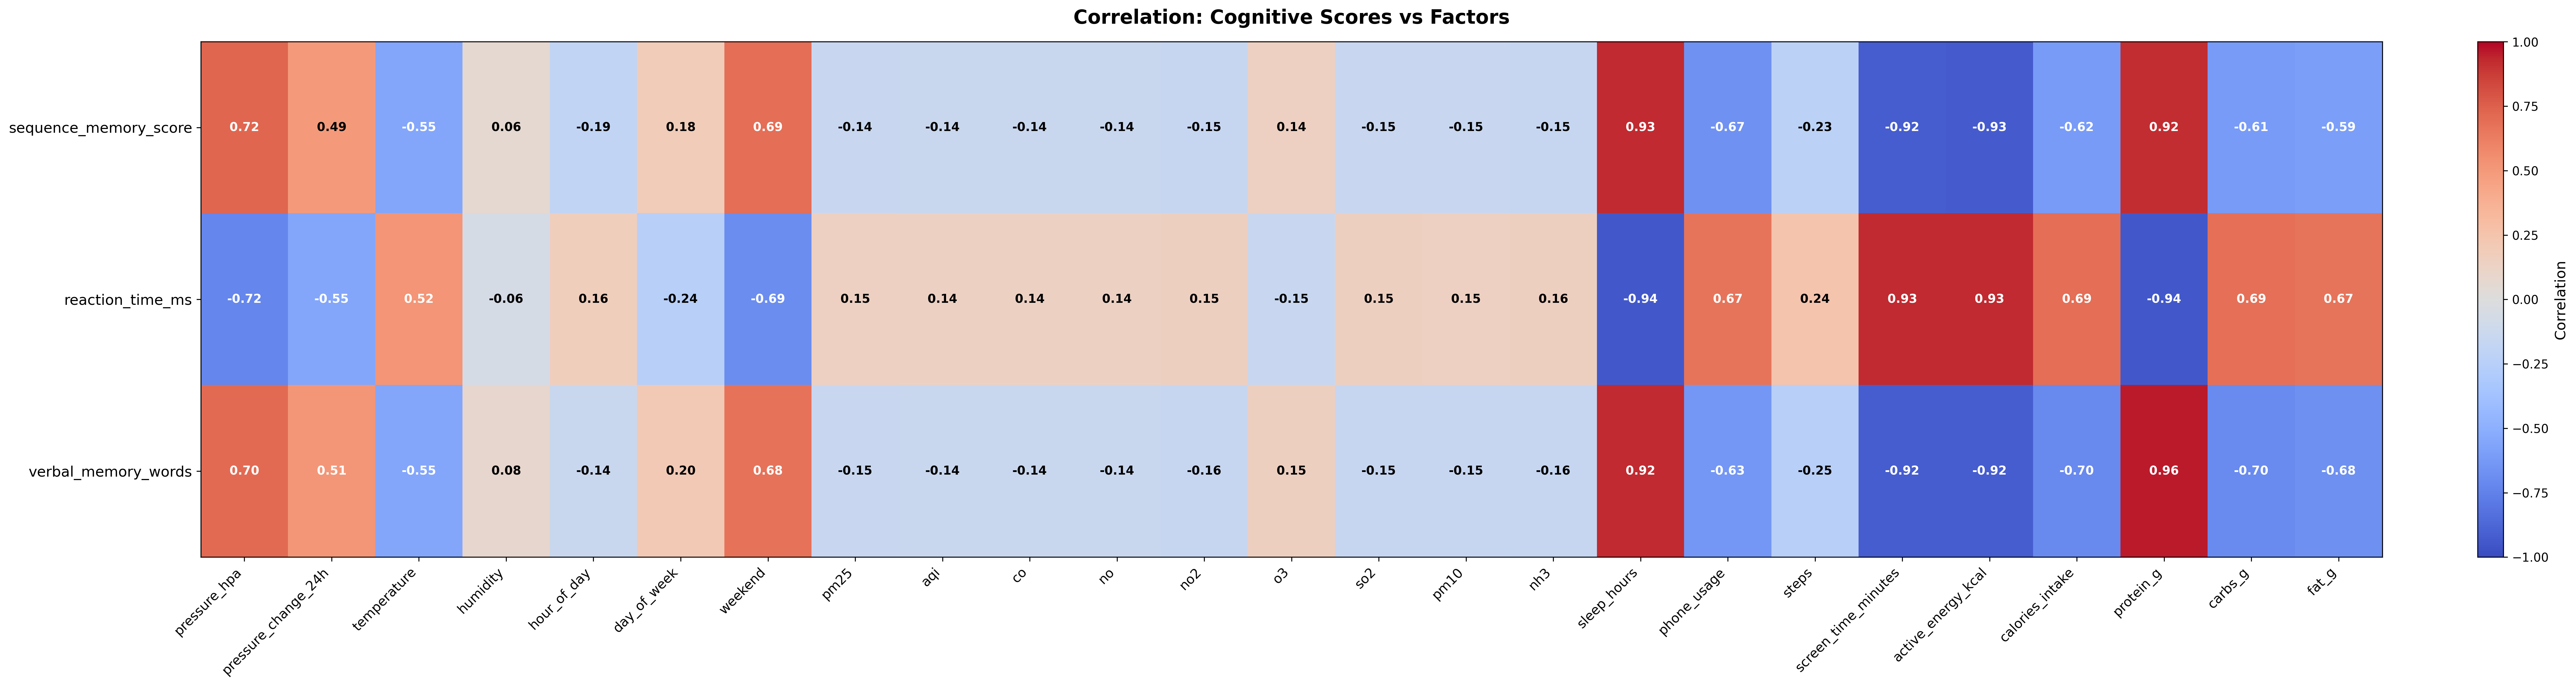

In [30]:
from IPython.display import Image, display

print("Correlation Heatmap:")
display(Image(filename=str(PROJECT_ROOT / 'reports/insights/correlation_heatmap.png'), width=800))


In [9]:
import json

with open(PROJECT_ROOT / 'reports/insights/ai_prompt_payload.json') as f:
    payload = json.load(f)

print(f"Dataset: {payload['summary']['rows']} measurements")
print("\nTop Correlations:")
for corr in payload['top_correlations'][:5]:
    print(f"  {corr['pair'][0]} ↔ {corr['pair'][1]}: {corr['corr']:.3f}")


Dataset: 168 measurements

Top Correlations:
  verbal_memory_words ↔ protein_g: 0.958
  reaction_time_ms ↔ protein_g: 0.943
  reaction_time_ms ↔ sleep_hours: 0.942
  reaction_time_ms ↔ screen_time_minutes: 0.930
  reaction_time_ms ↔ active_energy_kcal: 0.929


---
## Summary

The pipeline successfully:
1. ✓ Read behavioral & cognitive CSVs
2. ✓ Fetched external weather/air quality data
3. ✓ Validated and cleaned all records
4. ✓ Loaded data into PostgreSQL
5. ✓ Generated correlation heatmap
6. ✓ Created AI-powered PDF report

**Output:** `reports/insights/brain_fog_report.pdf`
